# Import

In [1]:
import cv2
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow import reduce_sum
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D, Conv2DTranspose
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
from sklearn import preprocessing

import tensorflow.keras.backend as K


import pydicom
import os
import numpy as np

# Data processsing

In [2]:
 def load_patients(path):
    img_size=128

    lstFilesDCM = []  # create an empty list
    for dirName, subdirList, fileList in os.walk(path):
        for filename in fileList:
            if ".dcm" in filename.lower():  # check whether the file's DICOM
                lstFilesDCM.append(os.path.join(dirName,filename))

    # Get ref file
    RefDs = pydicom.read_file(lstFilesDCM[0])

    # Load dimensions based on the number of rows, columns, and slices (along the Z axis)
    ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM))

    # Load spacing values (in mm)
    ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))

    # The array is sized based on 'ConstPixelDims'
    ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)
    image = []
    # loop through all the DICOM files
    for filenameDCM in lstFilesDCM:
        # read the file
        ds = pydicom.read_file(filenameDCM)
        # store the raw image data
        npa = ds.pixel_array
        npa = cv2.resize(npa,(img_size,img_size),interpolation = cv2.INTER_NEAREST) 
        image.append(npa)
       

    return np.array(image)


In [3]:
PathDicom_image = "C:\Projet Master\Data\SPECTANONYMOUS" # All the images indexed 

In [4]:
npa_imgs=load_patients(PathDicom_image)
npa_masks=load_patients(PathDicom_mask)


In [5]:
print(npa_imgs.shape,npa_masks.shape)

(4206, 128, 128) (4206, 128, 128)


In [6]:
np.max(npa_imgs)

32766

In [7]:
def shuffle_and_reshape(npa_imgs,npa_masks):
    shuffle_npa_imgs, shuffle_npa_masks=shuffle(npa_imgs,npa_masks, random_state=0)
    X = shuffle_npa_imgs.reshape((-1, 128, 128, 1))
    Y = shuffle_npa_masks.reshape((-1,128,128,1))
    return X,Y
    

In [8]:
X,Y=shuffle_and_reshape(npa_imgs,npa_masks)

In [9]:
X=X.astype('float16')

In [10]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)






# Model creation

In [11]:
def build_unet(shape):
    input_layer = Input(shape = shape)
    
    conv1 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(input_layer)
    conv1 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(conv1)
    pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)
    
    conv2 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(conv2)
    pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(conv3)
    pool3 = MaxPooling2D(pool_size = (2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(conv4)
    pool4 = MaxPooling2D(pool_size = (2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(conv5)
    
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides = (2, 2), padding = 'same')(conv5), conv4], axis = 3)
    conv6 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(up6)
    conv6 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides = (2, 2), padding = 'same')(conv6), conv3], axis = 3)
    conv7 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(up7)
    conv7 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(conv7)
    
    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides = (2, 2), padding = 'same')(conv7), conv2], axis = 3)
    conv8 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(up8)
    conv8 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides = (2, 2), padding = 'same')(conv8), conv1], axis = 3)
    conv9 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(up9)
    conv9 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation = 'sigmoid')(conv9)
    
    return Model(input_layer, conv10)

In [12]:
model = build_unet((128, 128, 1))
model.summary()
model.compile(optimizer = Adam(lr = 1e-5), loss = binary_crossentropy, metrics = [dice_coef])


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
model.fit(x=X, y=Y, batch_size=20, epochs=70, verbose=1, callbacks=None, validation_split=0.2)

In [ ]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(model.history.history['dice_coef'])
plt.plot(model.history.history['val_dice_coef'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.save("third_model_unet.h5")

# Reload the model and perform prediction

In [50]:
model=load_model('third_model_unet.h5',custom_objects={'dice_coef': dice_coef})

In [51]:
model.load_weights('third_model_unet.h5')

In [54]:
metrics=model.metrics

In [55]:
metrics

In [34]:
npa_imgs_test=load_patients("C:\Projet Master\Data\patient_test\image")

In [94]:
npa_mask_test=load_patients("C:\Projet Master\Data\patient_test\mask")

In [95]:
npa_imgs_test=npa_imgs_test.reshape((-1, 128, 128, 1))

In [96]:
result=model.predict(npa_imgs_test.astype('float16'))

In [97]:
result=result.astype('uint8')

# Show the result

Text(0.5, 1.0, 'Prediction slice 69')

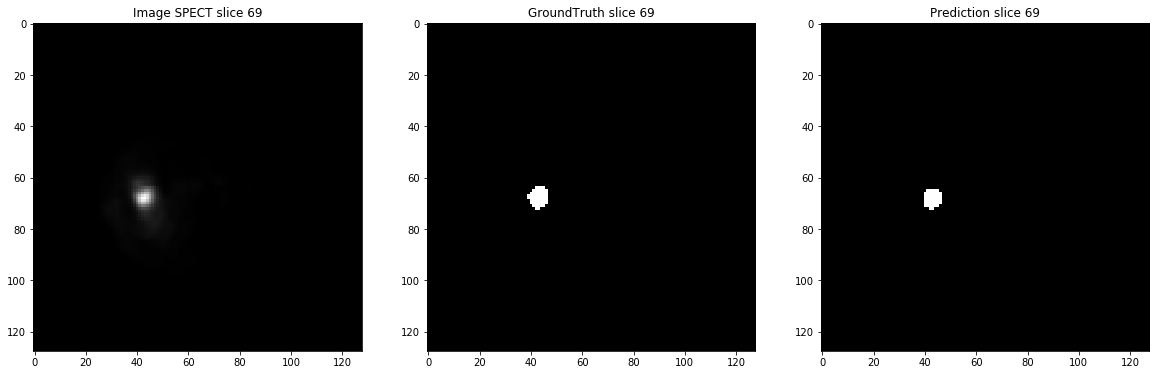

In [114]:
z=69
plt.figure(figsize=(20, 15))
plt.subplot(131)
plt.imshow(npa_imgs_test[z,:,:,0],cmap='gray')
plt.title("Image SPECT slice %i"%z)
plt.subplot(132)
plt.imshow(npa_mask_test[z,:,:],cmap='gray')
plt.title("GroundTruth slice %i"%z)
plt.subplot(133)
plt.imshow(result[z,:,:,0],cmap='gray')
plt.title("Prediction slice %i"%z)

# Metrics computation

In [21]:
def dice_and_IoU(im1, im2, empty_score=1.0,metrics="Dice"):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        Both are empty (sum eq to zero) = empty_score
        
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)
    union = np.logical_or(im1, im2)
    dice_coef = 2. * intersection.sum() / im_sum

    iou_score = np.sum(intersection) / np.sum(union)
    if metrics=='Dice':
        return dice_coef
    else:
        return iou_score
    


In [22]:
def vol_cube(npa):
    RefDs = pydicom.read_file("C:\Projet Master\Data\SEGMENTATION_FINALE\ScalarVolume_PAT_001\IMG0001.dcm")

    # Load dimensions based on the number of rows, columns, and slices (along the Z axis)
    ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), 1)

    # Load spacing values (in mm)
    ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))

    Volume_pixel=ConstPixelSpacing[0]*ConstPixelSpacing[1]*ConstPixelSpacing[2]
    nbr_pixel=np.count_nonzero(npa)
    
    return Volume_pixel,nbr_pixel,int(Volume_pixel)*int(nbr_pixel)*10**-3
    

In [23]:
def avg_dice_and_IoU(npa_pred,npa_mask):
    list_Dice=[]
    list_IoU=[]
    for i in range(0,len(npa_mask)):
        list_Dice.append(dice_and_IoU(npa_pred[i,:,:,0], npa_mask[i,:,:], empty_score=1.0,metrics="Dice"))
        list_IoU.append(dice_and_IoU(npa_pred[i,:,:,0], npa_mask[i,:,:], empty_score=1.0,metrics="IoU"))
        
        
    return np.array(list_Dice).mean(),np.array(list_IoU).mean()
        

In [24]:
avg_dice_and_IoU(result,npa_mask_test)

(0.8835283417983902, 0.8473138335182275)

In [25]:
vol_cube(result)

(21.75289632023024, 4261, 89.48100000000001)

In [26]:
vol_cube(npa_mask_test)

(21.75289632023024, 9451, 198.471)

In [27]:
import SimpleITK as sitk

import sys, time, os
import numpy as np

if len( sys.argv ) < 2:
    print( "Usage: python " + __file__ + "<output_directory>" )
    sys.exit ( 1 )

def writeSlices(series_tag_values, new_img, i):
    image_slice = new_img[:,:,i]

    # Tags shared by the series.
    list(map(lambda tag_value: image_slice.SetMetaData(tag_value[0], tag_value[1]), series_tag_values))

    # Slice specific tags.
    image_slice.SetMetaData("0008|0012", time.strftime("%Y%m%d")) # Instance Creation Date
    image_slice.SetMetaData("0008|0013", time.strftime("%H%M%S")) # Instance Creation Time

    # Setting the type to CT preserves the slice location.
    image_slice.SetMetaData("0008|0060", "CT")  # set the type to CT so the thickness is carried over

    # (0020, 0032) image position patient determines the 3D spacing between slices.
    image_slice.SetMetaData("0020|0032", '\\'.join(map(str,new_img.TransformIndexToPhysicalPoint((0,0,i))))) # Image Position (Patient)
    image_slice.SetMetaData("0020,0013", str(i)) # Instance Number

    # Write to the output directory and add the extension dcm, to force writing in DICOM format.
    writer.SetFileName(os.path.join("C:\Projet Master\Data\write_dicom",str(i)+'.dcm'))
    writer.Execute(image_slice)

# Create a new series from a numpy array
new_arr = np.random.uniform(-10, 10, size = (3,4,5)).astype(np.int16)
new_img = sitk.GetImageFromArray(new_arr)
new_img.SetSpacing([2.5,3.5,4.5])

# Write the 3D image as a series
# IMPORTANT: There are many DICOM tags that need to be updated when you modify an
#            original image. This is a delicate opration and requires knowlege of
#            the DICOM standard. This example only modifies some. For a more complete
#            list of tags that need to be modified see:
#                           http://gdcm.sourceforge.net/wiki/index.php/Writing_DICOM
#            If it is critical for your work to generate valid DICOM files,
#            It is recommended to use David Clunie's Dicom3tools to validate the files 
#                           (http://www.dclunie.com/dicom3tools.html).

writer = sitk.ImageFileWriter()
# Use the study/series/frame of reference information given in the meta-data
# dictionary and not the automatically generated information from the file IO
writer.KeepOriginalImageUIDOn()

modification_time = time.strftime("%H%M%S")
modification_date = time.strftime("%Y%m%d")

# Copy some of the tags and add the relevant tags indicating the change.
# For the series instance UID (0020|000e), each of the components is a number, cannot start
# with zero, and separated by a '.' We create a unique series ID using the date and time.
# tags of interest:
direction = new_img.GetDirection()
series_tag_values = [("0008|0031",modification_time), # Series Time
                  ("0008|0021",modification_date), # Series Date
                  ("0008|0008","DERIVED\\SECONDARY"), # Image Type
                  ("0020|000e", "1.2.826.0.1.3680043.2.1125."+modification_date+".1"+modification_time), # Series Instance UID
                  ("0020|0037", '\\'.join(map(str, (direction[0], direction[3], direction[6],# Image Orientation (Patient)
                                                    direction[1],direction[4],direction[7])))),
                  ("0008|103e", "Created-SimpleITK")] # Series Description

# Write slices to output directory
list(map(lambda i: writeSlices(series_tag_values, new_img, i), range(new_img.GetDepth())))
    
# Re-read the series
# Read the original series. First obtain the series file names using the
# image series reader.
data_directory = r"C:\Projet Master\Data\write_dicom"
series_IDs = sitk.ImageSeriesReader.GetGDCMSeriesIDs(data_directory)
if not series_IDs:
    print("ERROR: given directory \""+data_directory+"\" does not contain a DICOM series.")
    sys.exit(1)
series_file_names = sitk.ImageSeriesReader.GetGDCMSeriesFileNames(data_directory, series_IDs[0])

series_reader = sitk.ImageSeriesReader()
series_reader.SetFileNames(series_file_names)

# Configure the reader to load all of the DICOM tags (public+private):
# By default tags are not loaded (saves time).
# By default if tags are loaded, the private tags are not loaded.
# We explicitly configure the reader to load tags, including the
# private ones.
series_reader.LoadPrivateTagsOn()
image3D = series_reader.Execute()
print(image3D.GetSpacing(),'vs',new_img.GetSpacing())
sys.exit( 0 )

(2.5, 3.5, 4.5) vs (2.5, 3.5, 4.5)


SystemExit: 0

C:\Users\youve\Anaconda3\envs\projet-master\lib\site-packages\IPython\core\interactiveshell.py:3327: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [28]:
import pandas as pd

In [35]:
data = {'Dice':[0.88,0.93,0.96,0.96,0.39], 'IoU':[0.84,0.90,0.92,0.95,0.34], 'True_volume':[198,520,96,149,507],'Predicted_volume':[100,408,86,130,70]} 
metrics_DataFrame=pd.DataFrame(data)

In [36]:
metrics_DataFrame

,Dice,IoU,True_volume,Predicted_volume
0,0.88,0.84,198,100
1,0.93,0.90,520,408
2,0.96,0.92,96,86
3,0.96,0.95,149,130
4,0.39,0.34,507,70


In [37]:
metrics_DataFrame.describe()

,Dice,IoU,True_volume,Predicted_volume
count,5.000000,5.000000,5.000000,5.000000
mean,0.824000,0.790000,294.000000,158.800000
std,0.244806,0.254755,203.647981,141.043256
min,0.390000,0.340000,96.000000,70.000000
25%,0.880000,0.840000,149.000000,86.000000
50%,0.930000,0.900000,198.000000,100.000000
75%,0.960000,0.920000,507.000000,130.000000
max,0.960000,0.950000,520.000000,408.000000


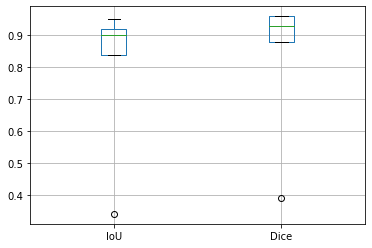

In [38]:
metrics_DataFrame[["IoU","Dice"]].boxplot()

In [39]:
metrics_DataFrame["diff_absolute_volume"]=(metrics_DataFrame["True_volume"]-metrics_DataFrame["Predicted_volume"])/metrics_DataFrame["True_volume"]

In [40]:
metrics_DataFrame

,Dice,IoU,True_volume,Predicted_volume,diff_absolute_volume
0,0.88,0.84,198,100,0.494949
1,0.93,0.90,520,408,0.215385
2,0.96,0.92,96,86,0.104167
3,0.96,0.95,149,130,0.127517
4,0.39,0.34,507,70,0.861933


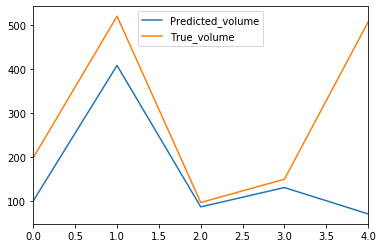

In [42]:
metrics_DataFrame[["Predicted_volume","True_volume"]].plot()

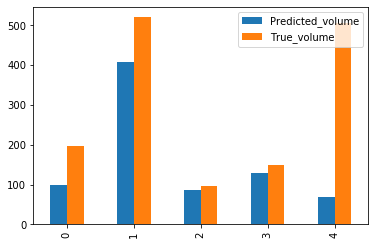

In [43]:
metrics_DataFrame.plot.bar(y=["Predicted_volume","True_volume"])


In [52]:
metrics_DataFrame["name"]=["patient 51","patient 24","patient 50","patient 16","patient 11"]

In [53]:
metrics_DataFrame


,Dice,IoU,True_volume,Predicted_volume,diff_absolute_volume,name
0,0.88,0.84,198,100,0.494949,patient 51
1,0.93,0.90,520,408,0.215385,patient 24
2,0.96,0.92,96,86,0.104167,patient 50
3,0.96,0.95,149,130,0.127517,patient 16
4,0.39,0.34,507,70,0.861933,patient 11


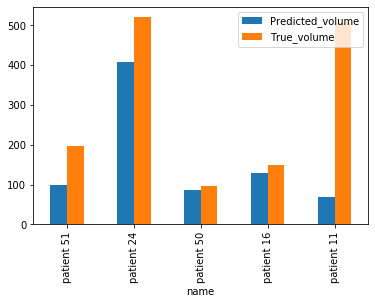

In [54]:
metrics_DataFrame.plot.bar(x="name",y=["Predicted_volume","True_volume"])
